# Задание

Решить задачу классификации рукописных цифр на датасете mnist https://www.kaggle.com/datasets/hojjatk/mnist-dataset. Правила следующие:
- нужно представить решение в виде нейронной сети, написанной на numpy, и обученной с помощью алгоритма градиентного спуска;
- нейронная сеть должна состоять из двух линейных слоев, активаций relu и softmax, и mse лосса;
- нельзя пользоваться автоградиентом (pytorch, numpy). Градиенты должны считаться вручную по алгоритму обратного распространения ошибки, используя аналитические формулы производных;
- решение считается валидным, если оно достигает аккураси больше 50%.

## Настройки/Гиперпараметры/Импорты

In [1]:
import matplotlib.pyplot as plt # для вывода графиков/картинок
import numpy as np # для работы с матрицами

import torchvision # для работы с картинками (преобразований)
import torch # для создания модели

# Загрузка и обработка данных

In [2]:
# преобразования над датасетом
transforms = torchvision.transforms.Compose([ # Compose объединяет несколько преобразований вместе, чтобы они выполнялись "последовательно"
    torchvision.transforms.ToTensor(), # преобразование PIL изображения (или ndarray формата (Height x Width x Channels)) в tensor (типа float со значениями в области [0.0, 1.0], если такая трансформация поддерживается (см описание ToTensor))
    torchvision.transforms.Normalize(mean=(0.1307,), std=(0.3081,)) # нормализация каналов (в датасете всего один канал) к указанным среднему значению и стандартному отклонению (цифры подобраны под датасет)
])

# датасет
data_train = torchvision.datasets.MNIST(root="./data", # путь, откуда брать/куда сохранять датасет
                                        train=True, # скачиание обучающей части датасета
                                        download=True, # скачивать ли датасет, если его нет в root пути
                                        transform=transforms # функция, принимающая на вход PIL Image и преобразовывающая его
                                       )

# загрузчик данных для обучения
train_loader = torch.utils.data.DataLoader(dataset=data_train, # указание датасета для DataLoader
                                           batch_size=20, # размер батчка (число сэмплов, что будет возвращать DataLoader за раз) (градиент усредняется по батчу, ускоряется обработка датасета, но слегка замедляется обработка сэмпла)
                                           num_workers=5, # число используемых ядер процессора для ускорения обработки данных
                                           pin_memory=True # нужно ли заранее аллоцировать память под объект на GPU (лучше так, чем возвращать CUDA tensors при multi-process loading)
                                          )

In [3]:
data_train # данные о датасете

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [4]:
data_train[0][0] # первое "изображение" датасета после применения трансформаций

tensor([[[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0

In [5]:
data_train[0][1] # класс (target) первого изображения

5

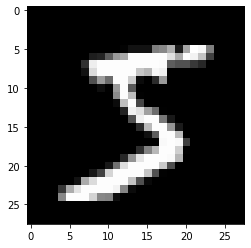

In [6]:
plt.imshow(data_train[0][0].reshape((28, 28, 1)), cmap='gray') # построение изображения
# .reshape((28, 28, 1)), так как shape(1, 28, 28) ~ (Channels, Height, Width) не воспринимается
# cmap='gray' так как изображение одноканальное, то есть чёрно-белое
plt.show() # вывод изображения

# Создание модели

## - Cross-Entropy loss

$$
Cross Entropy Loss(p^{pred}) = \dfrac{1}{batch\_size} \sum_{N=1}^{batch\_size} \sum_{C=1}^{classes} -p^{true}_{N,C}*log_e(p^{pred}_{N,C})
$$

$$
\dfrac{dCross Entropy Loss(p^{pred})}{dp^{pred}_{C}} = \dfrac{1}{batch\_size} \sum_{N=1}^{batch\_size} -\dfrac{p^{true}_{N,C}}{p^{pred}_{N,C}} + \dfrac{1-p^{true}_{N,C}}{1-p^{pred}_{N,C}}
$$

Без усреднения по батчу

$$
Cross Entropy Loss(p^{pred}_N) = \sum_{C=1}^{classes} -p^{true}_{N,C}*log_e(p^{pred}_{N,C}),\ где\ N\ -\ номер\ батча
$$

$$
\dfrac{dCross Entropy Loss(p^{pred}_N)}{dp^{pred}_{N,C}} = -\dfrac{p^{true}_{N,C}}{p^{pred}_{N,C}} + \dfrac{1-p^{true}_{N,C}}{1-p^{pred}_{N,C}},\ где\ N\ -\ номер\ батча
$$

In [7]:
class CrossEntropyLoss:
    def __init__(self):
        """
        Конструктор функции для подсчёта CrossEntropyLoss.
        """
        self.loss = None # значение подсчитанного loss
        self.grad = None # градиент размера (batch_size, classes)
        self.p_pred = None # 
        self.p_true = None
        self.batch_size = 1 # размер батча
        self.classes = 1 # число классов

    def calc_loss(self, p_pred, p_true) -> np.float64: # результат разниться с torch.nn.CrossEntropyLoss()!
        """
        Функция для подсчёта Cross-Entropy loss с усреднением по батчу.\n
        Parameters:
            * p_pred: предсказанные вероятности классов размера (batch_size, classes)
            * p_true: реальные вероятности классов размера (batch_size, classes)\n
        Returns:
            * np.float64: значение функции потерь
        """
        self.batch_size = p_true.shape[0] # размер батча
        self.classes = p_true.shape[1] # число классов
        loss = 0.0 # значение loss

        # workaround для того, чтобы избавиться от inf и nan
        p_pred[p_pred==0.0] = 0.000001 # заменяем полностью нулевые вероятности на очень малые - чтобы логарифм в формуле не давал -inf
        p_pred[p_pred==1.0] = 0.999999 # заменяем вероятности в 1 на очень высокие - чтобы в backward в формуле (1-self.p_true[batch][c])/(1-self.p_pred[batch][c])  не получился NaN
        p_true[p_true==0.0] = 0.000001 # заменяем полностью нулевые вероятности на очень малые - чтобы логарифм в формуле не давал -inf
        p_true[p_true==1.0] = 0.999999 # заменяем вероятности в 1 на очень высокие - чтобы в backward в формуле (1-self.p_true[batch][c])/(1-self.p_pred[batch][c])  не получился NaN

        for batch in range(self.batch_size): # идём по числу батчей (внешний цикл)
            #========== v1
            loss += np.matmul(p_true[batch], np.log(p_pred[batch])) # сумма по классам на определённом батче
            #========== v2
            # for c in range(classes):
            #     loss += p_true[batch][c] * np.log(p_pred[batch][c])
            #==========
        loss = - loss / self.batch_size # домножаем на -1 и берём среднее по батчам

        self.loss = loss # запоминаем подсчитанный loss

        #========== v1 (без усреднения градиента по батчам)
        self.grad = np.zeros(shape=(self.batch_size, self.classes)) # заготовка под матрицу градиентов
        #========== v2 (с усреднением градиента по батчам)
        # self.grad = np.zeros(shape=(self.classes)) # заготовка под матрицу градиентов (с усреднением по батчам)
        #==========

        self.p_pred = p_pred
        self.p_true = p_true
        return loss # возвращаем посчитанный loss
    

    def backward(self) -> np.ndarray:
        """
        Функция для подсчёта градиента после Cross-Entropy loss.\n
        Returns:
            * np.ndarray: значение градиента размер (batch_size, classes)
        """
        #========== v1 (если считать, что вход пришёл от softmax, то сразу возвращаем dloss/dsoftmax_input)
        # for batch in range(self.batch_size): # идём по номерам батчей
        #     #========== v1 с итерированием по классам
        #     for c in range(self.classes): # идём по классам
        #         self.grad[batch][c] = self.p_pred[batch][c] - self.p_true[batch][c] # считаем градиент при условии, что вход от softmax (см grad.png)
        #     #========== v2 без итерирования по классам (работаем с векторами-строками)
        #     self.grad[batch] = self.p_pred[batch] - self.p_true[batch] # считаем градиент при условии, что вход от softmax
        #     #==========
        #========== v1.1 (v1 с усреднением по батчам)
        # for batch in range(self.batch_size): # идём по номерам батчей
        #     #========== v1 с итерированием по классам
        #     # for c in range(self.classes): # идём по классам
        #     #     self.grad[c] += self.p_pred[batch][c] - self.p_true[batch][c] # считаем градиент (см grad.png)
        #     #========== v2 без итерирования по классам (работаем с векторами-строками)
        #     self.grad += self.p_pred[batch] - self.p_true[batch] # считаем градиент
        #     #==========
        # self.grad = self.grad / self.batch_size # усредняем градиент по числу батчей
        #========== v2 (общий случай)
        for batch in range(self.batch_size): # идём по номерам батчей
            #========== v1 с итерированием по классам
            # for c in range(self.classes): # идём по классам
            #     self.grad[batch][c] = -self.p_true[batch][c]/self.p_pred[batch][c] + (1-self.p_true[batch][c])/(1-self.p_pred[batch][c])
            #========== v2 без итерирования по классам (работаем с векторами-строками)
            self.grad[batch] = -(self.p_true[batch]/self.p_pred[batch]) + (1-self.p_true[batch])/(1-self.p_pred[batch]) # считаем градиент от предсказанных вероятностей
            #==========
        #========== v2.1 (v2 с усреднением по батчам)
        # for batch in range(self.batch_size): # идём по номерам батчей
        #     #========== v1 с итерированием по классам
        #     # for c in range(self.classes): # идём по классам
        #     #     self.grad[c] += -(self.p_true[batch][c]/self.p_pred[batch][c]) + (1-self.p_true[batch][c])/(1-self.p_pred[batch][c]) # считаем градиент от предсказанных вероятностей
        #     #========== v2 без итерирования по классам (работаем с векторами-строками)
        #     self.grad += -(self.p_true[batch]/self.p_pred[batch]) + (1-self.p_true[batch])/(1-self.p_pred[batch]) # считаем градиент от предсказанных вероятностей
        #     #==========
        # self.grad = self.grad / self.batch_size # усредняем градиент по числу батчей
        #==========

        return self.grad # возвращаем посчитанный градиент

### loss testing

In [8]:
probs_pred = np.array([[0.2,0.6,0.2], [1.0,0.0,0.0]])
# probs_pred = np.array([[1.0,0.0,0.0], [1.0,0.0,0.0]])
probs_pred = torch.tensor(probs_pred)

probs_true = np.array([[1.0,0.0,0.0], [1.0,0.0,0.0]])
probs_true = torch.tensor(probs_true)

loss_torch = torch.nn.CrossEntropyLoss()
loss_torch(probs_pred, probs_true)

tensor(0.9009, dtype=torch.float64)

In [9]:
loss_custom = CrossEntropyLoss()
loss_custom.calc_loss(probs_pred, probs_true)

tensor(0.8047, dtype=torch.float64)

In [10]:
loss_custom.backward()

array([[-4.99999375,  2.49999583,  1.24999375],
       [ 0.        ,  0.        ,  0.        ]])

## - ReLU

$$ 
ReLU(x) =  
\left\{
\begin{array}{ll}
      0 & if & x \leq 0 \\
      x & if & x > 0 \\
\end{array} 
\right.
$$

$$ 
\dfrac{dReLU(x)}{dx} =  
\left\{
\begin{array}{ll}
      0 & if & x \leq 0 \\
      1 & if & x > 0 \\
\end{array} 
\right.
$$

<center><img src="pics/ReLU.png"></center>

In [11]:
class ReLU():
    def __init__(self):
        """
        Конструктор ReLU функции.
        """
        self.prev_input = None # вход с предыдущего слоя


    def forward(self, x: np.ndarray) -> np.ndarray: # numpy.array — это просто удобная функция для создания numpy.ndarray
        """
        Функция активации ReLU, если значение в X меньше или равно нулю - оно становится нулём, иначе — остаётся прежним.\n
        Parameters:
            * x: данные в виде массива размера (batch_size, features)\n
        Returns:
            * np.ndarray: преобразованный x согласно работе функции активации
        """
        self.prev_input = x.copy() # запоминаем вход с предыдущего шага
        x[x<0] = 0.0 # заменяем все значения в x, что меньше нуля на ноль
        return x
    

    def backward(self, grad: np.ndarray) -> np.ndarray:
        """
        Функция для обратного прохода градиента.\n
        Parameters:
            * grad: градиент, пришедший со следующего шага\n
        Returns:
            * np.ndarray: градиент с учётом текущего шага, передающийся назад
        """
        grad[self.prev_input < 0] = 0 # зануляем градиент там, где вход был меньше нуля
        # как бы поэлементно умножаем пришедший градиент на матрицу из нулей и единиц (так как это производная ReLU) 
        return grad

## - Softmax

$$
Softmax(x) = \dfrac{e^{x_i}}{\sum_{j}e^{x_j}} = p_i,\ где\ i=\overline{1, N}
$$

$$
\dfrac{dSoftmax(x)}{dx_i} = \dfrac{e^{x_i}}{\sum_{j}e^{x_j}} (1 - \dfrac{e^{x_i}}{\sum_{j}e^{x_j}}) = p_i * (1 - p_i),\ где\ i=\overline{1, N}
$$

In [12]:
class Softmax():
    def __init__(self):
        """
        Конструктор Softmax функции.
        """
        # print("constructed")
        self.prev_input = None # вход с предыдущего слоя
        self.prev_out = None # выход со слоя


    def forward(self, x: np.ndarray) -> np.ndarray:
        """
        Функция Softmax, пересчитывающая для всех элементов массива x значение e^x_i/summ(e^x_i).\n
        Parameters:
            * x: данные в виде массива размерности (batch_size, class_count) ~ (размер батча, число классов)\n
        Returns:
            * np.ndarray: преобразованный X согласно формуле Softmax
        """
        prob = np.exp(x) # считаем экспоненту от всех элементов X (каждый элемент в X идёт как степень e)

        for batch in range(prob.shape[0]): # идём по батчам
            prob[batch] = prob[batch] / prob[batch].sum() # каждый элемент (экспоненту) в батче делим на сумму экспонент этого батча
        self.prev_out = prob.copy() # запоминаем выход слоя
        # print("prob\n", prob) # DEBUG
        return prob # возвращаем результат Softmax
    
    def backward(self, grad: np.ndarray) -> np.ndarray: # grad = dloss/dinput = dloss/dprob * dprob/dinput, где prob - выход слоя softmax
        """
        Функция для обратного прохода градиента.\n
        Parameters:
            * grad: градиент, пришедший со следующего шага\n
        Returns:
            * np.ndarray: градиент с учётом текущего шага, передающийся назад
        """
        #========== v1 (если в CrossEntropyLoss учитывается то, что вход от softmax ==> грубо говоря - пропускаем шаг с подсчётом dloss/dprob, а сразу считаем dloss/dinput)
        # return grad # просто возвращаем полученный градиент (при условии формулы в CrossEntropyLoss)
        #========== v2 (общий случай)
        return grad * self.prev_out * (1 - self.prev_out) # домножаем полученный градиент на значение производной (dot product - поэлементное умножение)
        #==========

### Softmax testing

In [13]:
# probs_pred = np.array([[0.2,0.6,0.2], [1.0,0.0,0.0]])
# probs_pred = np.array([[1.0,0.0,0.0], [1.0,0.0,0.0]])
input = np.array([[2.0,3.1,2.0], [10.0,0.0,0.0]]) # ==> probs_pred ~ [[0.2,0.6,0.2], [1.0,0.0,0.0]]

probs_true = np.array([[1.0,0.0,0.0], [1.0,0.0,0.0]])

soft = Softmax()
res = soft.forward(input)
print(res)

loss_custom = CrossEntropyLoss()
loss_custom.calc_loss(res, np.array([[1.0,0.0,0.0], [1.0,0.0,0.0]]))
grad = loss_custom.backward()
print(soft.backward(grad))

[[1.99833498e-01 6.00333004e-01 1.99833498e-01]
 [9.99909208e-01 4.53958078e-05 4.53958078e-05]]
[[-8.00165502e-01  6.00332004e-01  1.99832498e-01]
 [-8.97916157e-05  4.43958078e-05  4.43958078e-05]]


## - Linear layer

$$
Linear(x) = xW + b
$$
* x - вход размера (batch_size, in_features)
* W - матрица весов размера (in_features, out_features)
* b - вектор-строка для смещения размера (out_features)
* y - выход размера (batch_size, out_features)

$$
\dfrac{dLinear(x)}{dx} = W^T
$$

$$
\dfrac{dLinear(x)}{dW} = x^T
$$

$$
\dfrac{dLinear(x)}{db} = 1
$$

In [15]:
class Linear: # линейный слой без смещения (bias)
    def __init__(self, in_features, out_features):
        """
        Конструктор линейного слоя.
        """
        self.in_features = in_features
        self.out_features = out_features

        self.prev_input = None # вход с предыдущего слоя

        # задаём начальные данные для модели из равномерного распределения от -0.5 до 0.5
        self.W = np.random.uniform(low=-0.5, high=0.5, size=(in_features, out_features)) # матрица весов слоя
        self.bias = np.random.uniform(low=-0.5, high=0.5, size=(out_features)) # смещение как вектор-строка


    def forward(self, x):
        """
        Функция, применяющая веса и смещение к входным данным, чья размерность (batch_size, in_features).\n
        """
        self.prev_input = x.copy() # запоминаем вход с предыдущего шага

        #========== v1 (умножение на веса)
        res = np.matmul(x, self.W) # умножаем вход на веса (batch_size, in_features)x(in_features, out_features)=(batch_size, out_features)
        #========== v1.1
        # res = np.zeros(shape=(x.shape[0], self.out_features))
        # for batch in range(x.shape[0]):
        #     res[batch] = np.matmul(x[batch], w)
        #========== v1.2
        # res = np.zeros(shape=(x.shape[0], self.out_features))
        # for batch_id, batch in enumerate(x):
        #     res[batch_id] = np.matmul(batch, w)
        #==========

        #========== v1 (добавление смещения)
        res = np.add(res, self.bias) # добавляем смещение (bias) для каждого батча
        #========== v1.1
        # for batch in res:
        #     batch += self.bias
        #==========
        return res
        
    
    def backward(self, grad: np.ndarray, lr: np.float64=0.0001):
        """
        Функция для обратного прохода градиента (обновляющая веса и смещение).\n
        Parameters:
            * grad: градиент, пришедший со следующего шага\n
        Returns:
            * np.ndarray: градиент с учётом текущего шага, передающийся назад
        """
        # print("grad from next step", grad.shape) # (20, 10)
        # print("prev_input", self.prev_input.shape) # (20, 196)
        # print("prev_input.T", self.prev_input.T.shape) # (196, 20)
        # grad_W = np.matmul(grad, self.prev_input.T) # считаем градиент ошибки по весу W
        grad_W = np.matmul(self.prev_input.T, grad) # считаем градиент ошибки по весу W

        # print("current W", self.W.shape) # (196, 10)
        # print("grad_W", grad_W.shape) # (196, 10)
        # self.W = self.W - lr * grad_W.sum(axis=0)/grad_W.shape[0] # обновляем веса (усредняя градиент по батчам)
        self.W = self.W - lr * grad_W # обновляем веса

        grad_b = grad # считаем градиент ошибки по смещению
        self.bias = self.bias - lr * grad_b.sum(axis=0)/grad_b.shape[0] # обновляем смещение (усредняя градиент по батчам)
        # self.bias = self.bias - lr * grad_b
        
        grad = np.matmul(grad, self.W.T) # градиент для предыдущего слоя

        return grad 

### Linear testing

In [16]:
# пример данных для модели
x = torch.randn(size=(10, 5)) # вход
w = torch.randn(size=(5, 3)) # вес
b = torch.randn(3) # смещение

In [17]:
# вариант по батчам v1
res = np.zeros(shape=(10,3))
for batch in range(10):
    res[batch] = np.matmul(x[batch], w)
    res[batch] = np.add(res[batch], b)
res

array([[-1.40002194,  3.72322685,  0.40824163],
       [-0.79332903,  2.9594155 , -1.09498012],
       [ 0.65042424,  0.94367045,  0.35207057],
       [ 3.19763038,  1.75812763, -0.09431708],
       [-1.57512549, -0.4743821 ,  4.38424957],
       [-1.87161806,  3.35738999, -1.30589068],
       [-2.19743207, -1.08883315, -0.24993384],
       [ 2.70750448, -4.24223179,  2.55342877],
       [ 0.86797532,  1.01374426, -0.6921711 ],
       [-0.78623191,  0.98088628,  0.16687959]])

In [18]:
linear = Linear(5, 3)
linear.W = w.numpy()
linear.bias = b.numpy()
linear.forward(x.numpy())

array([[-1.400022  ,  3.7232268 ,  0.40824163],
       [-0.7933289 ,  2.9594154 , -1.0949801 ],
       [ 0.65042424,  0.94367045,  0.35207057],
       [ 3.1976304 ,  1.7581277 , -0.09431708],
       [-1.5751255 , -0.4743821 ,  4.3842497 ],
       [-1.871618  ,  3.35739   , -1.3058907 ],
       [-2.197432  , -1.0888331 , -0.24993384],
       [ 2.7075043 , -4.242232  ,  2.5534286 ],
       [ 0.86797535,  1.0137442 , -0.69217134],
       [-0.7862319 ,  0.9808863 ,  0.1668796 ]], dtype=float32)

In [19]:
# вариант по батчам v2
res = np.matmul(x, w)
for batch in res:
    batch += b
res

tensor([[-1.4000,  3.7232,  0.4082],
        [-0.7933,  2.9594, -1.0950],
        [ 0.6504,  0.9437,  0.3521],
        [ 3.1976,  1.7581, -0.0943],
        [-1.5751, -0.4744,  4.3842],
        [-1.8716,  3.3574, -1.3059],
        [-2.1974, -1.0888, -0.2499],
        [ 2.7075, -4.2422,  2.5534],
        [ 0.8680,  1.0137, -0.6922],
        [-0.7862,  0.9809,  0.1669]])

In [20]:
# однострочный вариант
np.add(np.matmul(x, w), b)

tensor([[-1.4000,  3.7232,  0.4082],
        [-0.7933,  2.9594, -1.0950],
        [ 0.6504,  0.9437,  0.3521],
        [ 3.1976,  1.7581, -0.0943],
        [-1.5751, -0.4744,  4.3842],
        [-1.8716,  3.3574, -1.3059],
        [-2.1974, -1.0888, -0.2499],
        [ 2.7075, -4.2422,  2.5534],
        [ 0.8680,  1.0137, -0.6922],
        [-0.7862,  0.9809,  0.1669]])

## - Model

In [21]:
class CustomNetwork():
    def __init__(self, in_features, out_features):
        # 196 = 784/4, то есть уменьшили в 4 раза
        self.linear1 = Linear(in_features, int(in_features/4)) # задаём первый линейный слой
        self.activation = ReLU() # задаём активацию
        self.linear2 = Linear(int(in_features/4), 10) # задаём второй линейный слой
        self.softmax = Softmax() # задаём softmax
        self.layers = [] # список всех слоёв модели
        self.layers.append(self.linear1)
        self.layers.append(self.activation)
        self.layers.append(self.linear2)
        self.layers.append(self.softmax)


    def forward(self, x: np.ndarray) -> np.ndarray:
        """
        Функция для вызова forward метода всех слоёв модели.\n
        Parameters:
            * x: данные на вход размера (batch_size, channels, height, width)\n
        Returns:
            * np.ndarray: результат вызова всех слоёв модели
        """
        x = x.reshape(x.shape[0], x.shape[1]*x.shape[2]*x.shape[3]) # "избавляемся" от размерностей channels, height, width, совмещаем их в одномерный массив -> получаем двумерный массив размера (batch_size, channels*height*width)
        for layer in self.layers: # идём по слоям модели
            x = layer.forward(x) # последовательно вызываем forward метод каждого слоя
        return x
    

    def backward(self, grad) -> None:
        """
        Функция для обновления весов модели.\n
        Parameters:
            * grad: значение градиента, используемое для обновления весов\n
        Returns:
            * None: обновляет веса модели путём градиентного спуска
        """
        for layer in reversed(self.layers): # идём по слоям в обратном порядке
            grad = layer.backward(grad) # обновляем веса у слоя и возвращаем изменённый loss 


# Обучение модели

In [22]:
def train(model, epochs: np.int64, train_loader, loss_func, num_classes: np.int64) -> list: # функция обучения
    """
    Функция обучения модели.\n
    Parameters:
        * model: модель для обучения
        * epochs: число эпох обучения
        * train_loader: загрузчик данных
        * loss_func: функция для подсчёта потерь
        * num_classes: число классов в задаче multi-class classification\n
    Returns:
        * list: список с получившимися значениями loss функции
    """
    losses = [0.0] * epochs # заготавливаем массив под значения loss функции
    for epoch in range(epochs): # обучаемся по эпохам
        for batch_idx, (data, target) in enumerate(train_loader): # идём по батчам, что возвращает train_loader
            # переводим target в вероятностное пространство (везде нули, кроме нужного таргета - там единица)
            # p_true = np.array([0.0 if i != target else 1.0 for i in range(num_classes)], dtype=np.float64) # переводим target в вероятностное пространство (везде нули, кроме нужного таргета - там единица)
            p_true = np.zeros(shape=(train_loader.batch_size, num_classes)) # заготовка под вероятности (пока заполнена нулями)
            for batch, t in enumerate(target): # идём по батчу (нескольким сэмплам), t - id правильного таргета
                p_true[batch][t] = 1.0 # ставим вероятность 1 у нужных таргетов (для всех элементов в батче)

            data = data.numpy() # переводим данные из формата tensor в numpy.array

            p_pred = model.forward(data) # вызываем forward pass модели (предсказываем)

            loss = loss_func.calc_loss(p_pred, p_true) # считаем loss модели
            losses[epoch] += loss/len(train_loader) # добавляем посчитанный на батче loss (делённый на len(train_loader) - число батчей, для усреднения)

            grad = loss_func.backward() # считаем градиент ошибки
            model.backward(grad) # обновляем веса модели
        print(f"loss on epoch {epoch+1}:\t {losses[epoch]}")
    return losses
        

In [23]:
num_classes = 10 # число классов (различных цифр)
epochs = 20 # число эпох обучения
model = CustomNetwork(in_features=np.prod(data_train[0][0].shape), out_features=num_classes) # np.prod(data_train[0][0].shape) - произведение всех размерностей входных данных
loss_func = CrossEntropyLoss()
losses = train(model=model, epochs=epochs, train_loader=train_loader, loss_func=loss_func, num_classes=num_classes)
# loss - кросс-энтропия (перекрёстная энтропия)
# CrossEntropyLoss на вход ожидает вероятность класса для всех k классов
# то есть массив с вероятностями для каждой из четырёх категорий новостей

loss on epoch 1:	 2.537830716006109
loss on epoch 2:	 1.0050197685861515
loss on epoch 3:	 0.7345215820300226
loss on epoch 4:	 0.5890121267976615
loss on epoch 5:	 0.4949086470272617
loss on epoch 6:	 0.4283844776784835
loss on epoch 7:	 0.3785665644713339
loss on epoch 8:	 0.34004839090185063
loss on epoch 9:	 0.30920815672639096
loss on epoch 10:	 0.2838382520074111
loss on epoch 11:	 0.26256859717990166
loss on epoch 12:	 0.24452216416955175
loss on epoch 13:	 0.2290318475164834
loss on epoch 14:	 0.21548709648942577
loss on epoch 15:	 0.20355054388626165
loss on epoch 16:	 0.19296611844565795
loss on epoch 17:	 0.1834970651124477
loss on epoch 18:	 0.17498793156753364
loss on epoch 19:	 0.16729490731098362
loss on epoch 20:	 0.16031013180308892


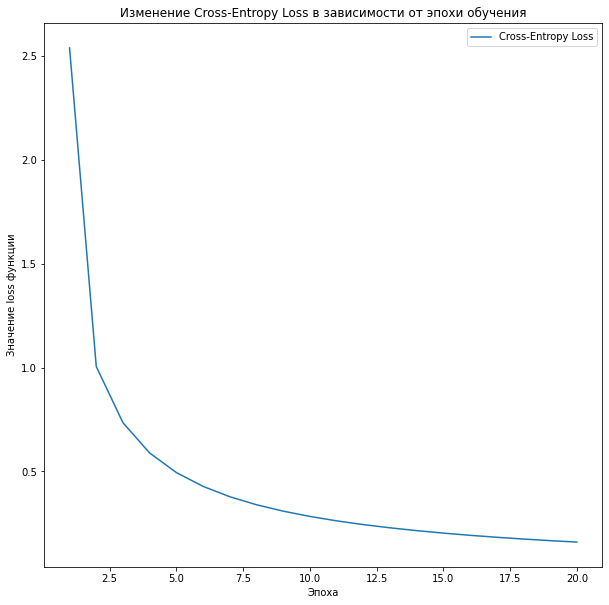

In [24]:
plt.figure(figsize=(10,10)) # размер графика
plt.title("Изменение Cross-Entropy Loss в зависимости от эпохи обучения") # название графика
plt.plot(range(1, epochs+1), losses, label="Cross-Entropy Loss") # построение графика, где range(1, epochs+1) — рассматриваемые значения x, losses — отображаемые значения, label — названия графика
plt.xlabel("Эпоха") # подпись по оси x
plt.ylabel("Значение loss функции") # подпись по оси y
plt.legend() # вывод названий графиков
plt.show() # вывод графика

# Проверка работы

In [25]:
data_train[0][0] # первый sample данных

tensor([[[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0

In [26]:
data_train[0][1] # его таргет

5

In [27]:
data = np.array([data_train[0][0]]) # конвертируем данные в формат np.array размера (batch_size, channels, height, width), так как изначально они размера (channels, height, width) и формата tensor
pred = model.forward(data) # делаем предсказание вероятностей классов
pred # вероятности классов

array([[7.66165886e-05, 7.65384096e-13, 2.13083707e-06, 1.32698713e-01,
        2.02157506e-17, 8.67219171e-01, 3.53080442e-21, 4.84264099e-13,
        4.43803039e-09, 3.36368073e-06]])

In [28]:
pred.argmax() # вывод индекса самого вероятного класса (совпадает с таргетом)

5